# Init

In [21]:
from IPython.display import clear_output
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal
from torchsummary import summary

from kan import *

import numpy as np
from collections import deque

import struct
import socket

import matlab.engine


import matplotlib.pyplot as plt

In [22]:
global_var = {

    # Connection
    'ip_address': '127.0.0.1',                  # Ip to connect
    'port_input': 8280,                         # Port where matlab send data
    'port_output': 8281,                        # Port where matlab receive data
    'port_f_input': 8282,                       # DEPRECATED: Same but for feedback branch
    'port_f_output': 8283,                      # DEPRECATED: Same but for feedback branch
    'buffer_size': 32,                          # Number of bytes to read 
    'connection_dim_input': 4,                  # Number of data to read -> used to unpack from byte, recevied data are byte
    'connection_dim_output': 3,                 # Number of data in output -> used to pack to byte and sedn to matlab
    'stop_flag': [-999, -999, -999, -999],      # DEPRECATED
    'use_pid': True,                            # DEPRECATED
        
    # Matlab
    'matlab_path': r'C:/Users/pc/Desktop/Artificial Intellingence & Robotics/1y-2s/Intelligent and hybrid control/IHC_attidute_control/control_schemas',
    'simulation_name': 'pid_full_schema.slx', 
    'simulation_time': 40.0,    # Time of the simulation
    'open_GUI': False,          # If True, it open the simulink schema

    # Dataset
    'max_len_dataset': 10000,

    # Feed Forward Network 
    'input_dim': 4,               # Dimension of input layer
    'output_dim': 3,              # Dimension of output layer
    'hidden_dim': 10,             # Dimension of hidden layer
    'output_range': 15,          # PID parameter max value
    'bias': True,                
    'learning_rate': 0.001,       
    'model_name': 'model.pt',     # Used to save weights
    'model_path': 'weights/',     # Folder where save weights

    # Train
    'batch_size': 32,             # Batch size for training
    'start_train_size': 1,        # DEPRECATED: Minium number of sample to traine
    'epochs': 3,                   
    'epoch_size': 20,             # Number of iteration on an epoch
    'frequency_update': 1000,     # Frequency update of the network

    # Plots
    'plots_path': 'plots/'        # Folder where save plots


}

class Color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'
    WHITE = '\033[97m'
    RESET = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Architecture

## Feed Forward Network

In [23]:
class FeedForwardNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim, output_range, bias ) -> None:
        super(FeedForwardNet, self).__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim =  output_dim
        
        self.output_range = output_range

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigm = nn.Sigmoid()

        self.layer_1 = KAN(width=[self.input_dim, self.hidden_dim])
        self.layer_2 = KAN(width=[self.hidden_dim, self.hidden_dim])
        self.layer_3 = KAN(width=[self.hidden_dim, self.hidden_dim])
        self.layer_4 = KAN(width=[self.hidden_dim, self.output_dim])
    
    
    def normalize_batch(self, x):
        if (len(x.shape) == 1):
            return x
        
        mean = x.mean(dim=0, keepdim=True)
        variance = x.var(dim=0, keepdim=True, unbiased=False)

        epsilon = 1e-5  # Small constant for numerical stability
        x_hat = (x - mean) / torch.sqrt(variance + epsilon) 

        return x_hat



    def forward(self, x):
        
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)

        x = self.layer_4(x)
        
        x = 0.5*(1+self.tanh(x))*self.output_range
        return x


In [24]:
class ControllerNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, output_range, lr, bias, model_name ) -> None:
        super(ControllerNetwork, self).__init__()

        self.network = FeedForwardNet(
            input_dim = input_dim,
            output_dim = output_dim,
            hidden_dim = hidden_dim,
            output_range=output_range,
            bias = bias
        )

        self.model_name = model_name
        self.loss_fnc = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        network_output = self.network(x)
        return network_output
    
    def save(self):
        name = self.model_name
        torch.save(self.state_dict(), name )
        #print(f"{Color.MAGENTA}Saved: {name}{Color.RESET}")

    def load(self):
        name = self.model_name
        try:
            self.load_state_dict(torch.load(name) )
            print(f"{Color.MAGENTA}loaded: {name}{Color.RESET}")
        except Exception as e:
            print(f"{Color.RED}Model not loaded{Color.RESET}")
            print(e)

# Utils


## Network

In [25]:
def setup_socket(ip_address, port_input):

    print(f"{Color.YELLOW}ip: {ip_address}, port_input: {port_input}{Color.RESET}")

    try:
        socket_nn_input = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        socket_nn_input.bind( (ip_address, port_input) )
        socket_nn_input.listen(1)

        print(f"{Color.BOLD}{Color.GREEN}Sockets listener created{Color.RESET}")

        return socket_nn_input
    except Exception as e:
        print(f"{Color.RED}An error occurred: {e}{Color.RESET}")

        if 'socket_nn_input' in locals():
            socket_nn_input.close()
            
        return None, None
    
def accept_connection(socket_server):
    connection, address = socket_server.accept()
    print(f"{Color.GREEN}Connection accepted!{Color.RESET}")
    return connection, address

def receive_data(connection, buffer_size, dim_input):
    
    expected_bytes = buffer_size  # Size for one double
    no_data_flag = False
    data = b''
    while len(data) < expected_bytes:
        more_data = connection.recv(expected_bytes - len(data))

        if not more_data:
            print("\nNo data received. Ending connection.")
            no_data_flag = True
            break

        data += more_data
    data = list(struct.unpack(f'!{str(dim_input)}d', data))  # Unpack one double
    
    return data, no_data_flag

def receive_data_excpt(connection, buffer_size, dim_input, stop_flag):
    
    expected_bytes = 8# buffer_size  # Size for one double
    data = b''
    #connection.settimeout(5.0)  # Set timeout to 5 seconds

    try:
        while len(data) < expected_bytes:
            #more_data = connection.recv(expected_bytes - len(data))
            more_data = connection.recv(expected_bytes)
            if not more_data:
                # No more data is available, break the loop
                break
            data += more_data
        try:
            #data = list(struct.unpack(f'!{str(dim_input)}d', data)) 
            data = list(struct.unpack(f'!d', data)) 
        except Exception as e:
            print(f"\n{e}")
            print(f"{Color.RED}\nProblem with unpacking, error: {e}{Color.RESET}")
            print(f"{Color.RED}May be due because return empty string when nothing is receive for a certain time{Color.RESET}")
            return stop_flag
        
    except Exception as e:

        print(f"\n{e}")
        if isinstance(e, socket.timeout):
            print(f"{Color.RED}\nTimeout error: No data received within the timeout period{Color.RESET}")
        else:
            print(f"{Color.RED}\nOther exception occurred: {e}{Color.RESET}")
            print(f"{Color.RED}Maybe due to some other error in the code{Color.RESET}")
            
        print(f"{Color.RED}May be due because return empty string when nothing is receive for a certain time{Color.RESET}")
        print(f"{Color.BLUE}\nNo data received within the timeout period, maybe some error of code{Color.RESET}")
       
        return stop_flag
    
    connection.settimeout(None)
    return data

def send_data(connection, message, dim_output):
    try:
        #message_to_send = struct.pack(f'!{str(dim_output)}d', *message)  
        message_to_send = struct.pack(f'!{str(dim_output)}d', *message)
        connection.sendall(message_to_send)

    except Exception as e:
        print(f"\rError sending float: {e}", end='')

def close_connections(*to_close):
    try:
        for c in to_close:
            c.close()
    except Exception as e:
        print(f"{Color.RED}\nFailed to close connection: verified the follwing error:\n{e}{Color.RESET}")
        return

    print(f"{Color.GREEN}\nSockets closed!{Color.RESET}")


## Simulink

In [26]:
def run_simulink(model_name, matlab_path, simulation_time):

    model_name = model_name.split('.')[0]

    print(f"\nStarting Matlab engine ... ", end='')
    future = matlab.engine.start_matlab(background=True)
    eng = future.result()  
    print(f"Started!")

    eng.cd(matlab_path)
    print("MATLAB working directory:", eng.pwd())

    if global_var['open_GUI'] == False:
        eng.load_system(model_name)
    else:
        eng.open_system(model_name, nargout=0)
        
    loaded_model = eng.bdroot()
    print(f"The currently loaded model is: {loaded_model}")

    eng.set_param(model_name, 'StartTime', '0', nargout=0)
    eng.set_param(model_name, 'StopTime', str(simulation_time), nargout=0)
    eng.set_param(model_name, 'SimulationCommand', 'start', nargout=0)

    return eng

def run_simulink_with_gui(model_name, matlab_path, simulation_time):

    model_name = model_name.split('.')[0]

    print(f"\nStarting Matlab engine ... ", end='')
    future = matlab.engine.start_matlab(background=True)
    eng = future.result()  
    print(f"Started!")

    eng.cd(matlab_path)
    print("MATLAB working directory:", eng.pwd())

    eng.open_system(model_name, nargout=0)
    loaded_model = eng.bdroot()

    print(f"The currently loaded model is: {loaded_model}")

    eng.set_param(model_name, 'StartTime', '0', nargout=0)
    eng.set_param(model_name, 'StopTime', str(simulation_time), nargout=0)
    eng.set_param(model_name, 'SimulationCommand', 'start', nargout=0)

    return eng

## Neural Network

In [27]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.5)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.1)

# Dataset

In [28]:
class ControllDataset(Dataset):
    def __init__(self):
        #self.data = []
        self.data = deque(maxlen=global_var['max_len_dataset'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        state, label = item[:-1], item[-1]
        return state, label

    def add_data(self, new_data):
        self.data.append(new_data)

# Setup and Train

In [29]:
def train(model, dataset, n_epochs, epoch_size, batch_size, shuffle):

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    iteration_epoch = 0
    for e in range(n_epochs):
        
        loss_value = 0
        iteration_epoch = 0

        for states, targets in dataloader:

            iteration_epoch += 1
            if iteration_epoch >= epoch_size:
                break

            model.optimizer.zero_grad()
            
            targets = targets.unsqueeze(1)
            
            modified_input = torch.cat((states, targets), dim=1)
            #_ = model( states )
            _ = model( modified_input )
           
            zeros_tensor = torch.zeros(targets.shape)
            
            l2_lambda = 0.001  # Example value for L2 regularization factor
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            l2_reg = l2_lambda*l2_norm

            loss = model.loss_fnc( targets, zeros_tensor ) + l2_reg
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            

            model.optimizer.step()

            loss_value += loss.item()

        model.save()
        
    return loss.mean()

In [30]:
def plot_statistics(history_error, history_desired_input, history_reference_model, history_controlled_object, history_mean_error, name):
    time = np.linspace(0, int(global_var['simulation_time']), len(history_error))

    fig, axs = plt.subplots(2,3,figsize=(18, 10))


    axs[0, 0].plot(time, history_desired_input)
    axs[0, 0].set_title('Desired input')
    axs[0, 0].grid(True)

    axs[0, 1].plot(time, history_reference_model)
    axs[0, 1].set_title('Reference model')
    axs[0, 1].grid(True)

    axs[1, 0].plot(time, history_controlled_object)
    axs[1, 0].set_title('Controlled object')
    axs[1, 0].grid(True)


    axs[0, 2].plot(time, history_error)
    axs[0, 2].set_title('Error')
    axs[0, 2].grid(True)


    axs[1, 2].plot(time, history_mean_error)
    axs[1, 2].set_title('Abs mean error - last 50')
    axs[1, 2].grid(True)


    axs[1, 1].axis('off')
    plt.tight_layout()

    fig_name = name + '_' + 'range_' + str(global_var['output_range']) + '_sim_' + global_var['simulation_name'].split('.')[0] + '_' + str(int(global_var['simulation_time']))
    print(fig_name)

    plt.grid(True)
    plt.savefig(global_var['plots_path'] + fig_name)
    plt.show(block=False)
    #plt.pause(0.1)

In [31]:
def main_loop(connection_receiver, 
                  connection_sender, 
                  network,
                  dataset, 
                  history_desired_input, 
                  history_reference_model,
                  history_controlled_object,
                  history_error,
                  history_mean_error,
                  mean_error_window,
                  train_flag
                  ):
    
    n_received = 0
    n_sent = 0
    n_train = 0
    mean_loss = 0
    
    while True:

        raw_data, _ = receive_data(
            connection=connection_receiver, 
            buffer_size=global_var['buffer_size'],
            dim_input=global_var['connection_dim_input'],
            #stop_flag=global_var['stop_flag']
            )
        
        n_received += 1
        
        #raw_data = [raw_data[0], raw_data[1], raw_data[2], pid.tunings[0], pid.tunings[1], pid.tunings[2], raw_data[3]]
        
        history_controlled_object.append(raw_data[0])
        history_desired_input.append(raw_data[1])
        history_reference_model.append(raw_data[2])
        history_error.append(raw_data[-1])
        history_mean_error.append(abs(np.mean(history_error[-mean_error_window:])))
        
        raw_data = torch.tensor(raw_data)

        
        data = raw_data.detach().clone().requires_grad_(True)
        if train_flag == True:
            dataset.add_data(data)
        
        if ( n_received % global_var['frequency_update'] ) == 0 and len(dataset) > 0 and train_flag == True:
            
            current_loss = 0
            mean_loss = 0
            
            current_loss = train(
                model=network,
                dataset=dataset,
                n_epochs=global_var['epochs'],
                epoch_size=global_var['epoch_size'],
                batch_size=global_var['batch_size'],
                shuffle=True
            )  
            n_train += 1
            mean_loss = (current_loss + mean_loss).mean()

        network_input = raw_data #[: -1]

        net_output = network(network_input.unsqueeze(0)).squeeze(0)
            
        net_output = net_output.detach()
        
        pid_parameters = net_output
    
        #output = [5.0, 2.0, 2.0]

        send_data(
            connection=connection_sender, 
            message=net_output, 
            dim_output=global_var['connection_dim_output']
            )
        n_sent += 1
        
        #print(f"\rreceived: {n_received}, sent: {n_sent}, n_data: {len(dataset)}, n_train: {n_train}, pid_parameters: ({pid_parameters[0]:.4f}, {pid_parameters[1]:.4f}, {pid_parameters[2]:.4f}),  error: {raw_data[-1]:.3f}, mean_error: {np.mean(history_error):.4f}, mean loss: {mean_loss:.2f}", end="")

        output_line = (
            f"\rreceived: {n_received}, sent: {n_sent}, n_data: {len(dataset)}, n_train: {n_train}, "
            f"pid_parameters: ({pid_parameters[0]:.4f}, {pid_parameters[1]:.4f}, {pid_parameters[2]:.4f}), "
            f"error: {raw_data[-1]:.4f}, mean_error_{str(mean_error_window)}: {np.mean(history_error[-mean_error_window:]):.4f} ,mean loss: {mean_loss:.4f}{' ' * 50}"
        )
        
        print(output_line, end='')

In [32]:
def initialization_connection_and_simulink( ip_address, 
                                            port_input, 
                                            port_output,
                                            simulation_name,
                                            simulation_time,
                                            matlab_path
                                            ):
    receiver_socket = setup_socket(
        ip_address=ip_address, 
        port_input=port_input
        )

    send_socket = setup_socket(
        ip_address=ip_address, 
        port_input=port_output
        )
        

    #eng = run_simulink_with_gui(model_name, eng_path, simulation_time)
    
    eng = run_simulink(
        model_name=simulation_name, 
        matlab_path=matlab_path, 
        simulation_time=simulation_time
        )


    print(f"{Color.CYAN}\nWaiting someone to connect ...{Color.RESET}")
    connection_receiver, addr = accept_connection(receiver_socket)
    connection_sender, addr = accept_connection(send_socket)

    return receiver_socket, send_socket, connection_receiver, connection_sender, eng

# Main

In [33]:
network = ControllerNetwork(  
                            input_dim=global_var['input_dim'],
                            output_dim=global_var['output_dim'],
                            hidden_dim=global_var['hidden_dim'],
                            bias=global_var['bias'],
                            output_range=global_var['output_range'],
                            lr=global_var['learning_rate'],
                            model_name=global_var['model_path']+global_var['model_name']
                            )

#network.apply(init_weights)

In [34]:
receiver_socket, send_socket, connection_receiver, connection_sender, eng = initialization_connection_and_simulink(
                                                                                                                    ip_address=global_var['ip_address'],
                                                                                                                    port_input=global_var['port_input'],
                                                                                                                    port_output=global_var['port_output'],
                                                                                                                    simulation_name=global_var['simulation_name'],
                                                                                                                    simulation_time=global_var['simulation_time'],
                                                                                                                    matlab_path=global_var['matlab_path']
                                                                                                                   )


ip: 127.0.0.1, port_input: 8280
Sockets listener created
ip: 127.0.0.1, port_input: 8281
Sockets listener created

Starting Matlab engine ... Started!
MATLAB working directory: C:\Users\pc\Desktop\Artificial Intellingence & Robotics\1y-2s\Intelligent and hybrid control\IHC_attidute_control\control_schemas
The currently loaded model is: pid_full_schema

Waiting someone to connect ...
Connection accepted!
Connection accepted!


In [35]:
# https://simple-pid.readthedocs.io/en/latest/reference.html

dataset = ControllDataset()
n_received = 0
n_sent = 0
previous_error = 0

pid_parameters = [-999.9, -999.9, -999.9] # dummy

history_desired_input = []
history_reference_model = []
history_controlled_object = []
history_error = []
history_mean_error = []

mean_error_window = 50
mean_loss = 0
n_train = 0


In [36]:
try:
    main_loop(
        connection_receiver=connection_receiver, 
        connection_sender=connection_sender, 
        network=network,
        dataset=dataset, 
        history_desired_input=history_desired_input, 
        history_reference_model=history_reference_model,
        history_controlled_object=history_controlled_object,
        history_error=history_error,
        history_mean_error=history_mean_error,
        mean_error_window=mean_error_window,
        train_flag = True
        )
except Exception as e:
    print()
    print(e)
    pass

finally:

    close_connections(
        connection_receiver,
        connection_sender,
        send_socket,
        receiver_socket,
    )

    eng.quit()
    pass

received: 6294, sent: 6294, n_data: 6294, n_train: 6, pid_parameters: (7.4909, 7.4925, 7.4855), error: -0.0832, mean_error_50: -0.0834 ,mean loss: 1.0132                                                  
[WinError 10054] Connessione in corso interrotta forzatamente dall'host remoto

Sockets closed!


train_range_15_sim_pid_full_schema_40


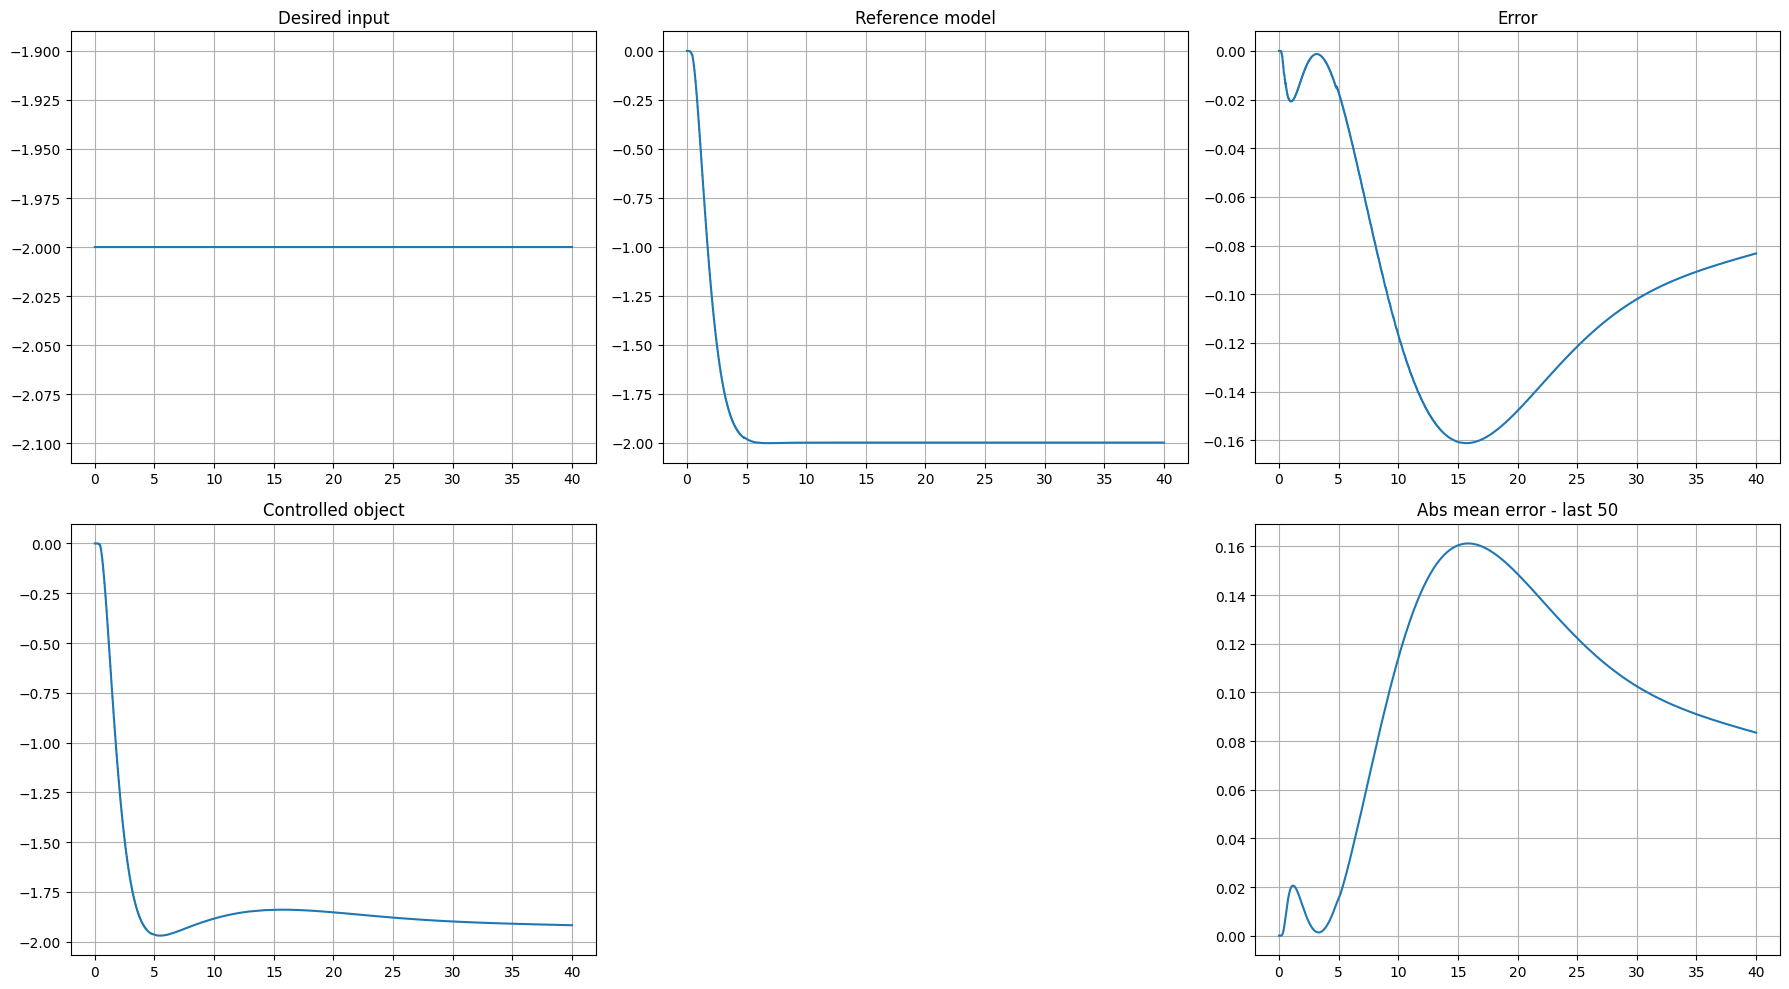

In [37]:
plot_statistics(
    history_error=history_error,
    history_desired_input=history_desired_input,
    history_reference_model=history_reference_model,
    history_controlled_object=history_controlled_object,
    history_mean_error=history_mean_error,
    name='train'
    )

# Test model

In [38]:
receiver_socket, send_socket, connection_receiver, connection_sender, eng = initialization_connection_and_simulink(
                                                                                                                    ip_address=global_var['ip_address'],
                                                                                                                    port_input=global_var['port_input'],
                                                                                                                    port_output=global_var['port_output'],
                                                                                                                    simulation_name='pid_full_schema_pulse.slx',
                                                                                                                    simulation_time=global_var['simulation_time'],
                                                                                                                    matlab_path=global_var['matlab_path']
                                                                                                                   )
 

ip: 127.0.0.1, port_input: 8280
Sockets listener created
ip: 127.0.0.1, port_input: 8281
Sockets listener created

Starting Matlab engine ... Started!
MATLAB working directory: C:\Users\pc\Desktop\Artificial Intellingence & Robotics\1y-2s\Intelligent and hybrid control\IHC_attidute_control\control_schemas
The currently loaded model is: pid_full_schema_pulse

Waiting someone to connect ...
Connection accepted!
Connection accepted!


In [39]:

dataset = ControllDataset()

pid_parameters = [-999.9, -999.9, -999.9] # dummy

history_desired_input = []
history_reference_model = []
history_controlled_object = []
history_error = []
history_mean_error = []

mean_error_window = 50


In [40]:
try:
    main_loop(
        connection_receiver=connection_receiver, 
        connection_sender=connection_sender, 
        network=network,
        dataset=dataset, 
        history_desired_input=history_desired_input, 
        history_reference_model=history_reference_model,
        history_controlled_object=history_controlled_object,
        history_error=history_error,
        history_mean_error=history_mean_error,
        mean_error_window=mean_error_window,
        train_flag = False
        )
except Exception as e:
    print()
    print(e)
    pass

finally:

    close_connections(
        connection_receiver,
        connection_sender,
        send_socket,
        receiver_socket,
    )

    eng.quit()
    pass

received: 6184, sent: 6184, n_data: 0, n_train: 0, pid_parameters: (7.5176, 7.5149, 7.5233), error: 1.0007, mean_error_50: 1.0146 ,mean loss: 0.0000                                                    
[WinError 10054] Connessione in corso interrotta forzatamente dall'host remoto

Sockets closed!


test_range_15_sim_pid_full_schema_40


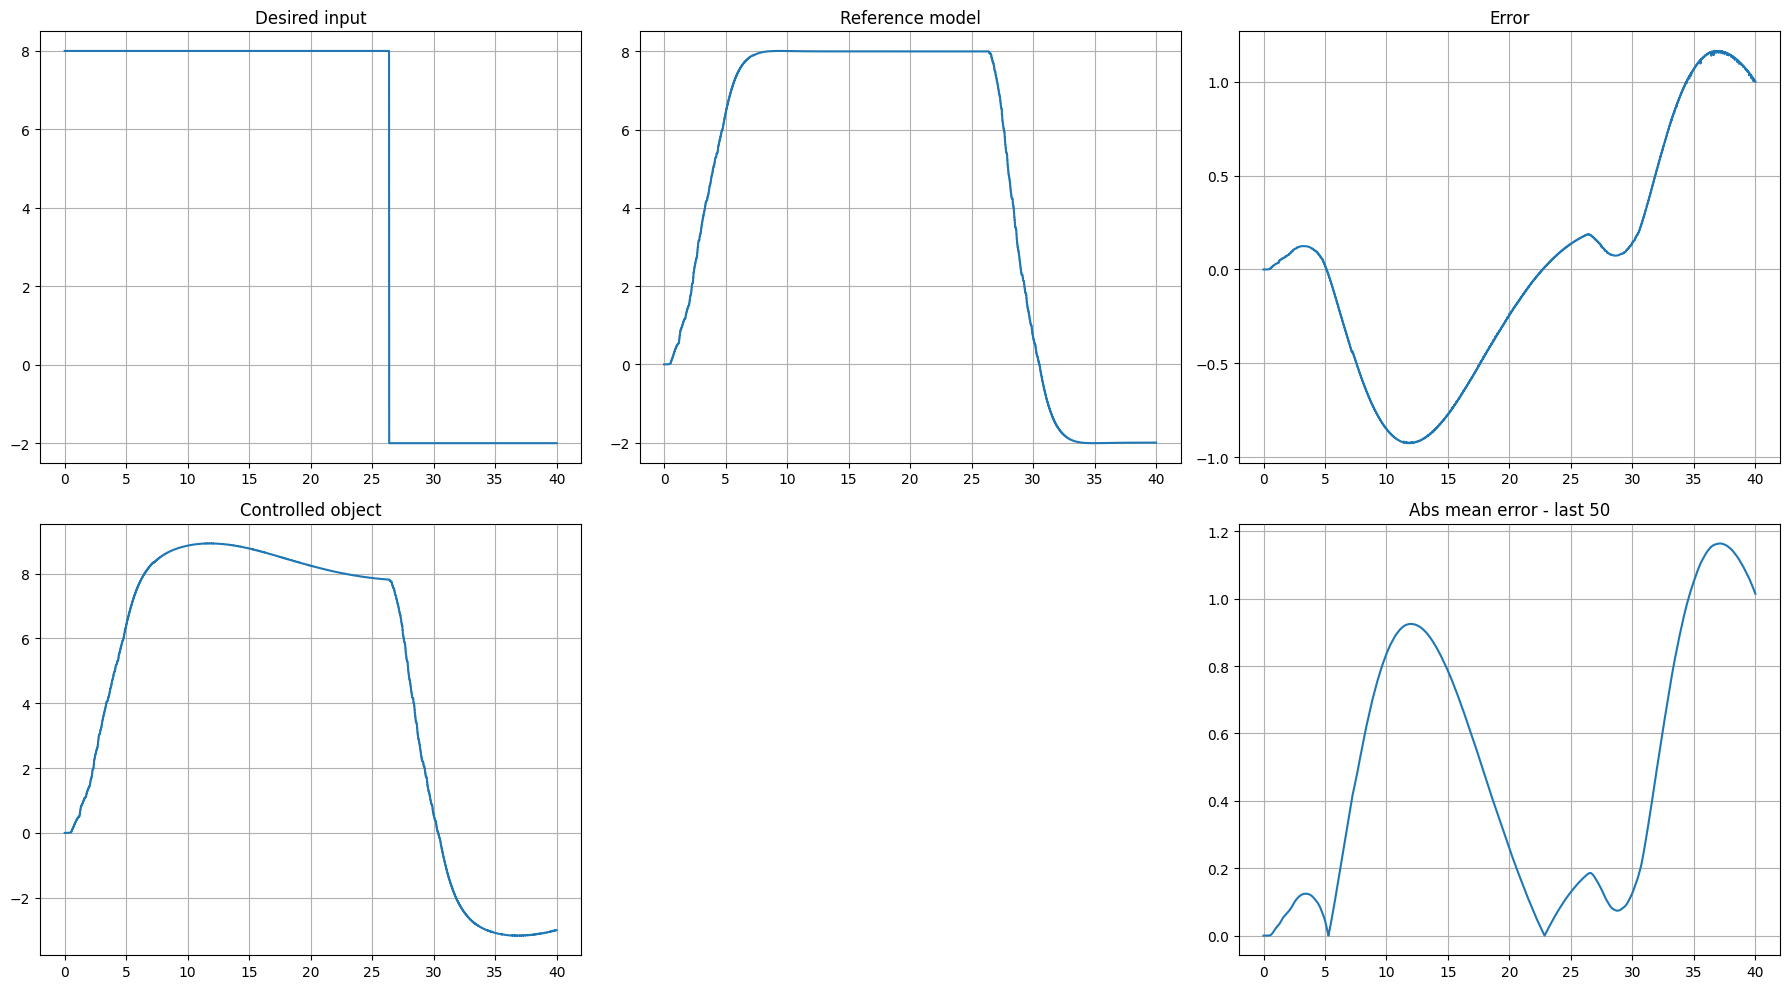

In [41]:
plot_statistics(
    history_error=history_error,
    history_desired_input=history_desired_input,
    history_reference_model=history_reference_model,
    history_controlled_object=history_controlled_object,
    history_mean_error=history_mean_error,
    name='test'
    )